# AgroGraphNet: Graph Construction

This notebook constructs farm network graphs based on spatial proximity, environmental similarity, and other relationships.

## Objectives:
1. Create spatial adjacency matrices based on farm locations
2. Calculate environmental similarity between farms
3. Build NetworkX graphs with node and edge features
4. Convert to PyTorch Geometric format
5. Create temporal graph sequences
6. Analyze graph properties and connectivity

In [1]:
# Import required libraries
import sys
import os
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from pathlib import Path
import torch
from torch_geometric.data import Data
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

# Import custom modules
from config import *
from data_utils import *
from graph_utils import *
from visualization import *

# Set random seed for reproducibility
np.random.seed(RANDOM_SEED)

print("Libraries imported successfully!")
print(f"Loading processed data from: {PROCESSED_DATA_DIR}")

Libraries imported successfully!
Loading processed data from: C:\Users\Ash09\agro_tech\AgroGraphNet\notebooks\..\data\processed


## 1. Load Processed Data

Load the preprocessed data from the previous notebook.

In [2]:
# Load processed data
print("Loading processed datasets...")

# Load feature matrix (should be created by notebook 02)
features_file = PROCESSED_DATA_DIR / 'features_scaled.csv'
if features_file.exists():
    features_df = pd.read_csv(features_file)
    features_df['date'] = pd.to_datetime(features_df['date'])
    print(f"✅ Loaded feature matrix: {features_df.shape}")
else:
    # If not available, load from raw data and create basic features
    print("⚠️ Processed features not found. Loading raw data...")
    
    # Load raw datasets
    farm_files = list(FARM_LOCATIONS_DIR.glob('*.csv'))
    weather_files = list(WEATHER_DIR.glob('*.csv'))
    disease_files = list(DISEASE_LABELS_DIR.glob('*.csv'))
    
    if not all([farm_files, weather_files, disease_files]):
        raise FileNotFoundError("Raw data files not found. Please run notebook 01 first.")
    
    farms_df = pd.read_csv(farm_files[0])
    weather_df = load_weather_data(str(weather_files[0]))
    disease_df = load_disease_labels(str(disease_files[0]))
    
    # Create basic feature matrix
    features_df = create_basic_feature_matrix(farms_df, weather_df, disease_df)
    print(f"✅ Created basic feature matrix: {features_df.shape}")

# Load farm locations
farm_files = list(FARM_LOCATIONS_DIR.glob('*.csv'))
if farm_files:
    farms_df = pd.read_csv(farm_files[0])
    print(f"✅ Loaded farm locations: {len(farms_df)} farms")
else:
    raise FileNotFoundError("Farm locations not found.")

print(f"\nData overview:")
print(f"- Features shape: {features_df.shape}")
print(f"- Time points: {features_df['date'].nunique()}")
print(f"- Unique farms: {features_df['farm_id'].nunique()}")
print(f"- Disease classes: {features_df['disease_type'].nunique() if 'disease_type' in features_df.columns else 'N/A'}")

Loading processed datasets...
✅ Loaded feature matrix: (1200, 37)
✅ Loaded farm locations: 100 farms

Data overview:
- Features shape: (1200, 37)
- Time points: 12
- Unique farms: 100
- Disease classes: 5


In [3]:
def create_basic_feature_matrix(farms_df, weather_df, disease_df):
    """
    Create a basic feature matrix if processed features are not available
    """
    print("Creating basic feature matrix...")
    
    # Get unique time points
    time_points = sorted(disease_df['date'].unique())
    
    feature_data = []
    
    for time_point in time_points:
        for _, farm in farms_df.iterrows():
            farm_id = farm['farm_id']
            
            # Basic farm features
            farm_features = {
                'farm_id': farm_id,
                'date': time_point,
                'lat': farm['lat'],
                'lon': farm['lon'],
                'area_hectares': farm['area_hectares']
            }
            
            # Add crop type (one-hot encoded)
            for crop_type in farms_df['crop_type'].unique():
                farm_features[f'crop_{crop_type}'] = int(farm['crop_type'] == crop_type)
            
            # Add basic weather features
            farm_weather = weather_df[
                (abs(weather_df['lat'] - farm['lat']) < 0.01) & 
                (abs(weather_df['lon'] - farm['lon']) < 0.01) &
                (weather_df['date'] == time_point)
            ]
            
            if len(farm_weather) > 0:
                farm_features['temperature'] = farm_weather['temperature'].mean()
                farm_features['humidity'] = farm_weather['humidity'].mean()
                farm_features['precipitation'] = farm_weather['precipitation'].mean()
                farm_features['wind_speed'] = farm_weather['wind_speed'].mean()
            else:
                # Use overall averages
                time_weather = weather_df[weather_df['date'] == time_point]
                farm_features['temperature'] = time_weather['temperature'].mean()
                farm_features['humidity'] = time_weather['humidity'].mean()
                farm_features['precipitation'] = time_weather['precipitation'].mean()
                farm_features['wind_speed'] = time_weather['wind_speed'].mean()
            
            # Add disease labels
            farm_disease = disease_df[
                (disease_df['farm_id'] == farm_id) & 
                (disease_df['date'] == time_point)
            ]
            
            if len(farm_disease) > 0:
                farm_features['disease_type'] = farm_disease['disease_type'].iloc[0]
                disease_mapping = {'Healthy': 0, 'Blight': 1, 'Rust': 2, 'Mosaic': 3, 'Bacterial': 4}
                farm_features['disease_label'] = disease_mapping.get(farm_disease['disease_type'].iloc[0], 0)
                farm_features['severity'] = farm_disease['severity'].iloc[0]
            else:
                farm_features['disease_type'] = 'Healthy'
                farm_features['disease_label'] = 0
                farm_features['severity'] = 0.0
            
            feature_data.append(farm_features)
    
    return pd.DataFrame(feature_data)

## 2. Create Distance Matrix and Spatial Adjacency

Creating distance matrix...
✅ Distance matrix created: (100, 100)
Distance statistics:
- Mean distance: 85.00 km
- Median distance: 78.99 km
- Max distance: 280.84 km
- Min distance: 0.66 km


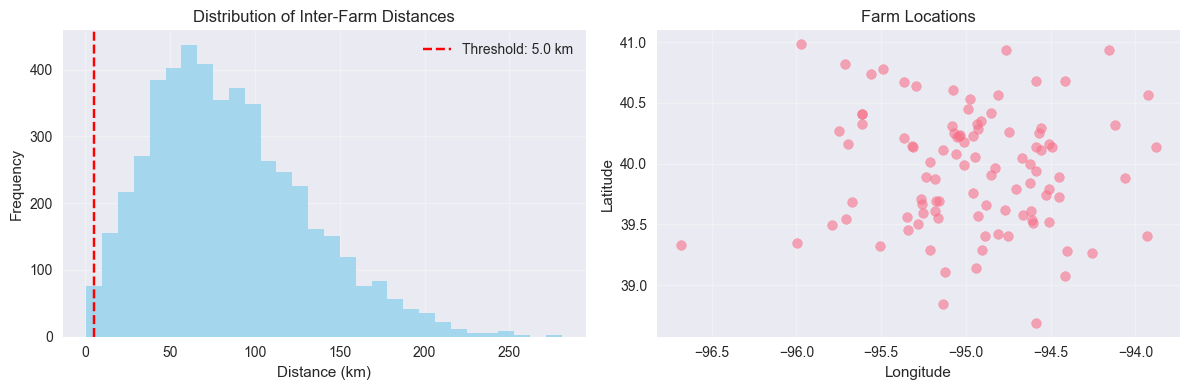

✅ Distance analysis completed


In [4]:
# Create distance matrix between farms
print("Creating distance matrix...")

distance_matrix = create_distance_matrix(farms_df)
print(f"✅ Distance matrix created: {distance_matrix.shape}")

# Analyze distance distribution
distances_flat = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]
print(f"Distance statistics:")
print(f"- Mean distance: {distances_flat.mean():.2f} km")
print(f"- Median distance: {np.median(distances_flat):.2f} km")
print(f"- Max distance: {distances_flat.max():.2f} km")
print(f"- Min distance: {distances_flat.min():.2f} km")

# Visualize distance distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(distances_flat, bins=30, alpha=0.7, color='skyblue')
plt.axvline(GRAPH_CONFIG['distance_threshold_km'], color='red', linestyle='--', 
           label=f'Threshold: {GRAPH_CONFIG["distance_threshold_km"]} km')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.title('Distribution of Inter-Farm Distances')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(farms_df['lon'], farms_df['lat'], alpha=0.6, s=50)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Farm Locations')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / '03_distance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Distance analysis completed")

Creating adjacency matrix...
✅ Adjacency matrix created: (100, 100)

Graph statistics:
- Nodes: 100
- Edges: 134.0
- Density: 0.0271
- Average degree: 2.68


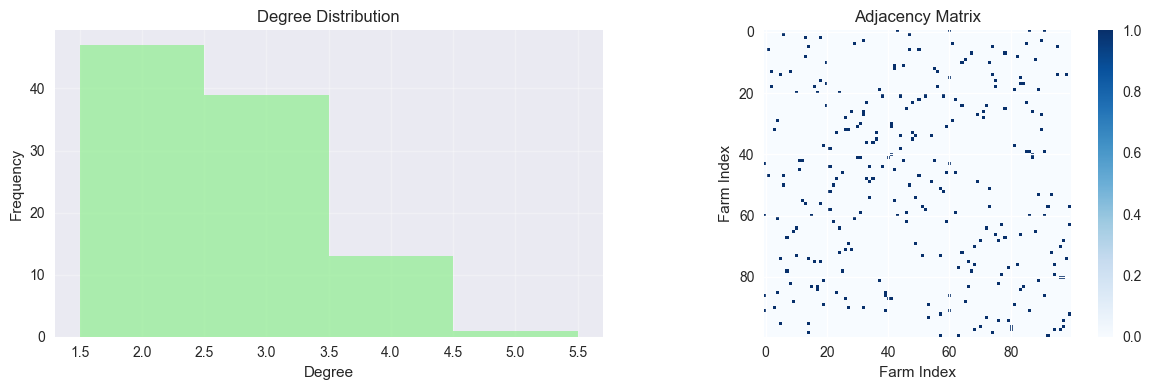

✅ Adjacency analysis completed


In [5]:
# Create adjacency matrix
print("Creating adjacency matrix...")

adjacency_matrix = create_adjacency_matrix(
    distance_matrix,
    threshold_km=GRAPH_CONFIG['distance_threshold_km'],
    min_neighbors=GRAPH_CONFIG['min_neighbors'],
    max_neighbors=GRAPH_CONFIG['max_neighbors']
)

print(f"✅ Adjacency matrix created: {adjacency_matrix.shape}")

# Analyze graph connectivity
num_edges = adjacency_matrix.sum() // 2  # Divide by 2 for undirected graph
num_nodes = adjacency_matrix.shape[0]
density = num_edges / (num_nodes * (num_nodes - 1) / 2)
avg_degree = adjacency_matrix.sum(axis=1).mean()

print(f"\nGraph statistics:")
print(f"- Nodes: {num_nodes}")
print(f"- Edges: {num_edges}")
print(f"- Density: {density:.4f}")
print(f"- Average degree: {avg_degree:.2f}")

# Visualize degree distribution
degrees = adjacency_matrix.sum(axis=1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(degrees, bins=range(int(degrees.min()), int(degrees.max()) + 2), 
         alpha=0.7, color='lightgreen', align='left')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.imshow(adjacency_matrix, cmap='Blues', interpolation='nearest')
plt.title('Adjacency Matrix')
plt.xlabel('Farm Index')
plt.ylabel('Farm Index')
plt.colorbar()

plt.tight_layout()
plt.savefig(RESULTS_DIR / '03_adjacency_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Adjacency analysis completed")

## 3. Calculate Environmental Similarity

Calculating environmental similarity...
Processing time point 1/12: 2023-01-31 00:00:00
Processing time point 2/12: 2023-02-28 00:00:00
Processing time point 3/12: 2023-03-31 00:00:00
Processing time point 4/12: 2023-04-30 00:00:00
Processing time point 5/12: 2023-05-31 00:00:00
Processing time point 6/12: 2023-06-30 00:00:00
Processing time point 7/12: 2023-07-31 00:00:00
Processing time point 8/12: 2023-08-31 00:00:00
Processing time point 9/12: 2023-09-30 00:00:00
Processing time point 10/12: 2023-10-31 00:00:00
Processing time point 11/12: 2023-11-30 00:00:00
Processing time point 12/12: 2023-12-31 00:00:00

✅ Environmental similarity calculated for 12 time points


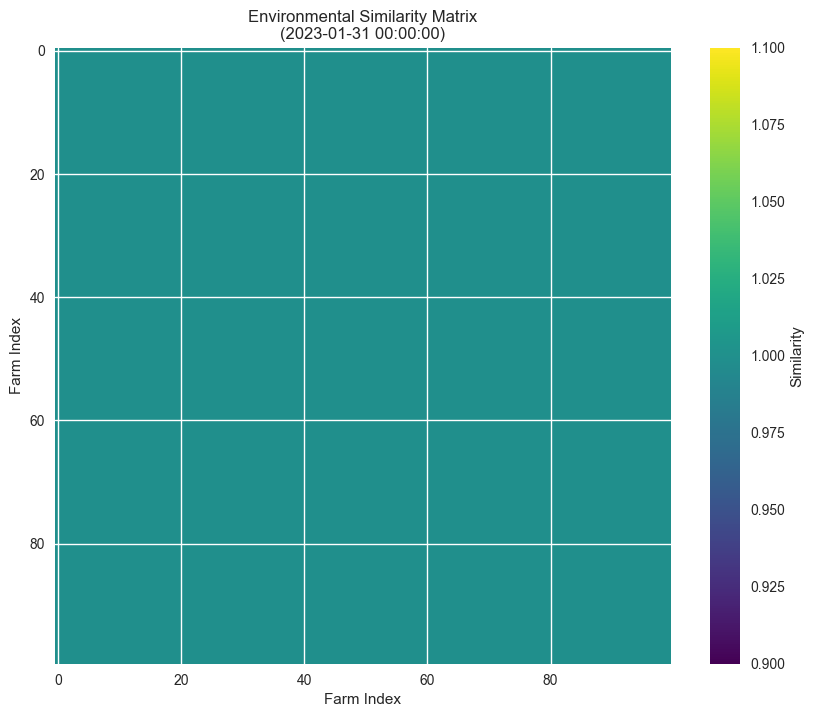

✅ Environmental similarity visualization completed


In [6]:
# Calculate environmental similarity for each time point
print("Calculating environmental similarity...")

time_points = sorted(features_df['date'].unique())
environmental_similarities = {}

for i, time_point in enumerate(time_points):
    print(f"Processing time point {i+1}/{len(time_points)}: {time_point}")
    
    # Get data for this time point
    time_data = features_df[features_df['date'] == time_point].copy()
    time_data = time_data.sort_values('farm_id').reset_index(drop=True)
    
    # Select environmental features
    env_features = ['temperature', 'humidity', 'precipitation', 'wind_speed']
    available_features = [f for f in env_features if f in time_data.columns]
    
    if available_features:
        # Calculate environmental similarity
        from sklearn.metrics.pairwise import cosine_similarity
        from sklearn.preprocessing import StandardScaler
        
        env_data = time_data[available_features].fillna(0)
        
        # Standardize features
        scaler = StandardScaler()
        env_data_scaled = scaler.fit_transform(env_data)
        
        # Calculate similarity
        env_similarity = cosine_similarity(env_data_scaled)
        
        # Ensure similarity is between 0 and 1
        env_similarity = (env_similarity + 1) / 2
        
    else:
        # If no environmental features available, use uniform similarity
        env_similarity = np.ones((len(time_data), len(time_data)))
    
    environmental_similarities[time_point] = env_similarity

print(f"\n✅ Environmental similarity calculated for {len(time_points)} time points")

# Visualize environmental similarity for first time point
first_time_point = time_points[0]
first_similarity = environmental_similarities[first_time_point]

plt.figure(figsize=(10, 8))
plt.imshow(first_similarity, cmap='viridis', interpolation='nearest')
plt.title(f'Environmental Similarity Matrix\n({first_time_point})')
plt.xlabel('Farm Index')
plt.ylabel('Farm Index')
plt.colorbar(label='Similarity')
plt.savefig(RESULTS_DIR / '03_environmental_similarity.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Environmental similarity visualization completed")

## 4. Create NetworkX Graphs

In [7]:
# Create NetworkX graphs for each time point
print("Creating NetworkX graphs...")

networkx_graphs = {}

for i, time_point in enumerate(time_points):
    print(f"Creating graph {i+1}/{len(time_points)}: {time_point}")
    
    # Get data for this time point
    time_data = features_df[features_df['date'] == time_point].copy()
    time_data = time_data.sort_values('farm_id').reset_index(drop=True)
    
    # Prepare node features (exclude metadata)
    exclude_cols = ['farm_id', 'date', 'disease_type', 'disease_label', 'severity']
    feature_cols = [col for col in time_data.columns if col not in exclude_cols]
    
    node_features = time_data[feature_cols].fillna(0).values
    
    # Prepare edge features
    edge_features = {
        'distance': distance_matrix,
        'environmental_similarity': environmental_similarities[time_point]
    }
    
    # Create NetworkX graph
    G = create_networkx_graph(
        adjacency_matrix,
        node_features,
        edge_features,
        farms_df
    )
    
    networkx_graphs[time_point] = G

print(f"\n✅ Created {len(networkx_graphs)} NetworkX graphs")

# Analyze graph properties for first graph
first_graph = networkx_graphs[time_points[0]]
graph_properties = analyze_graph_properties(first_graph)

print(f"\nGraph properties (first time point):")
for prop, value in graph_properties.items():
    if isinstance(value, float):
        print(f"- {prop}: {value:.4f}")
    else:
        print(f"- {prop}: {value}")

Creating NetworkX graphs...
Creating graph 1/12: 2023-01-31 00:00:00
Creating graph 2/12: 2023-02-28 00:00:00
Creating graph 3/12: 2023-03-31 00:00:00
Creating graph 4/12: 2023-04-30 00:00:00
Creating graph 5/12: 2023-05-31 00:00:00
Creating graph 6/12: 2023-06-30 00:00:00
Creating graph 7/12: 2023-07-31 00:00:00
Creating graph 8/12: 2023-08-31 00:00:00
Creating graph 9/12: 2023-09-30 00:00:00
Creating graph 10/12: 2023-10-31 00:00:00
Creating graph 11/12: 2023-11-30 00:00:00
Creating graph 12/12: 2023-12-31 00:00:00

✅ Created 12 NetworkX graphs

Graph properties (first time point):
- num_nodes: 100
- num_edges: 134
- density: 0.0271
- avg_clustering: 0.4823
- avg_degree: 2.6800
- diameter: inf
- avg_path_length: inf
- num_components: 5


## 5. Visualize Graph Structure

Creating graph visualizations...
✅ Graph visualization created
Creating interactive graph map...
✅ Interactive graph map saved to C:\Users\Ash09\agro_tech\AgroGraphNet\notebooks\..\results\03_graph_network_map.html


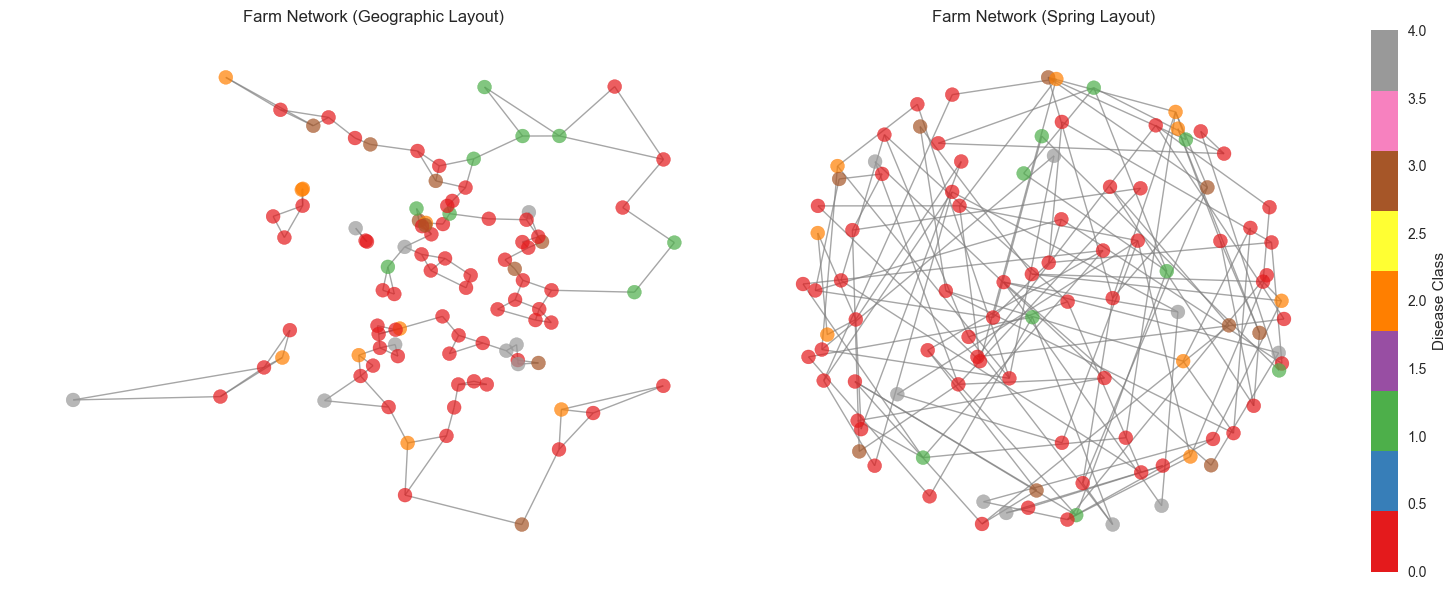

In [8]:
# Visualize graph structure
print("Creating graph visualizations...")

# Get disease labels for coloring
first_time_data = features_df[features_df['date'] == time_points[0]].copy()
first_time_data = first_time_data.sort_values('farm_id').reset_index(drop=True)

if 'disease_label' in first_time_data.columns:
    node_labels = first_time_data['disease_label'].values
else:
    node_labels = None

# Create graph visualization
fig = plot_graph_network(
    first_graph,
    farms_df,
    node_labels=node_labels,
    save_path=str(RESULTS_DIR / '03_graph_visualization.png')
)

print("✅ Graph visualization created")

# Create interactive map showing graph connections
print("Creating interactive graph map...")

center_lat = farms_df['lat'].mean()
center_lon = farms_df['lon'].mean()

import folium

# Create base map
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=10,
    tiles='OpenStreetMap'
)

# Add farm nodes
for i, (_, farm) in enumerate(farms_df.iterrows()):
    # Color by disease status if available
    if node_labels is not None:
        disease_colors = {0: 'green', 1: 'red', 2: 'orange', 3: 'purple', 4: 'darkred'}
        color = disease_colors.get(node_labels[i], 'blue')
    else:
        color = 'blue'
    
    folium.CircleMarker(
        location=[farm['lat'], farm['lon']],
        radius=8,
        popup=f"Farm: {farm['farm_id']}<br>Degree: {first_graph.degree(i)}",
        color='black',
        fillColor=color,
        fillOpacity=0.7,
        weight=2
    ).add_to(m)

# Add edges (sample of edges to avoid clutter)
edges = list(first_graph.edges())
sample_edges = edges[::max(1, len(edges)//50)]  # Sample every nth edge

for edge in sample_edges:
    farm1 = farms_df.iloc[edge[0]]
    farm2 = farms_df.iloc[edge[1]]
    
    folium.PolyLine(
        locations=[[farm1['lat'], farm1['lon']], [farm2['lat'], farm2['lon']]],
        color='gray',
        weight=1,
        opacity=0.5
    ).add_to(m)

# Save map
m.save(str(RESULTS_DIR / '03_graph_network_map.html'))
print(f"✅ Interactive graph map saved to {RESULTS_DIR / '03_graph_network_map.html'}")

## 6. Convert to PyTorch Geometric Format

In [9]:
# Convert NetworkX graphs to PyTorch Geometric format
print("Converting to PyTorch Geometric format...")

pytorch_graphs = []

for i, time_point in enumerate(time_points):
    print(f"Converting graph {i+1}/{len(time_points)}: {time_point}")
    
    # Get NetworkX graph
    G = networkx_graphs[time_point]
    
    # Get labels for this time point
    time_data = features_df[features_df['date'] == time_point].copy()
    time_data = time_data.sort_values('farm_id').reset_index(drop=True)
    
    if 'disease_label' in time_data.columns:
        labels = time_data['disease_label'].values
    else:
        labels = np.zeros(len(time_data))  # Default to healthy
    
    # Convert to PyTorch Geometric
    data = networkx_to_pytorch_geometric(G, labels)
    
    # Add metadata
    data.time_point = time_point
    data.num_farms = len(farms_df)
    
    pytorch_graphs.append(data)

print(f"\n✅ Converted {len(pytorch_graphs)} graphs to PyTorch Geometric format")

# Display information about the graphs
sample_graph = pytorch_graphs[0]
print(f"\nSample graph information:")
print(f"- Number of nodes: {sample_graph.x.shape[0]}")
print(f"- Node feature dimension: {sample_graph.x.shape[1]}")
print(f"- Number of edges: {sample_graph.edge_index.shape[1]}")
print(f"- Edge feature dimension: {sample_graph.edge_attr.shape[1] if sample_graph.edge_attr is not None else 0}")
print(f"- Number of classes: {len(torch.unique(sample_graph.y))}")
print(f"- Class distribution: {torch.bincount(sample_graph.y).tolist()}")

Converting to PyTorch Geometric format...
Converting graph 1/12: 2023-01-31 00:00:00


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

## 7. Save Graph Data

In [ ]:
# Save all graph data
print("Saving graph data...")

# Save processed features if not already saved
if not (PROCESSED_DATA_DIR / 'features_scaled.csv').exists():
    features_df.to_csv(PROCESSED_DATA_DIR / 'features_scaled.csv', index=False)
    print(f"✅ Features saved to {PROCESSED_DATA_DIR / 'features_scaled.csv'}")

# Save graph structures
graph_data = {
    'pytorch_graphs': pytorch_graphs,
    'networkx_graphs': networkx_graphs,
    'adjacency_matrix': adjacency_matrix,
    'distance_matrix': distance_matrix,
    'environmental_similarities': environmental_similarities,
    'time_points': time_points,
    'graph_properties': graph_properties,
    'farms_df': farms_df
}

with open(GRAPHS_DIR / 'farm_graphs.pkl', 'wb') as f:
    pickle.dump(graph_data, f)

print(f"✅ Graph data saved to {GRAPHS_DIR / 'farm_graphs.pkl'}")

# Save graph statistics
graph_stats = {
    'num_graphs': len(pytorch_graphs),
    'num_nodes': sample_graph.x.shape[0],
    'node_feature_dim': sample_graph.x.shape[1],
    'num_edges': sample_graph.edge_index.shape[1],
    'edge_feature_dim': sample_graph.edge_attr.shape[1] if sample_graph.edge_attr is not None else 0,
    'num_classes': len(torch.unique(sample_graph.y)),
    'graph_density': float(density),
    'avg_degree': float(avg_degree),
    'distance_threshold_km': GRAPH_CONFIG['distance_threshold_km'],
    'min_neighbors': GRAPH_CONFIG['min_neighbors'],
    'max_neighbors': GRAPH_CONFIG['max_neighbors']
}

with open(GRAPHS_DIR / 'graph_statistics.json', 'w') as f:
    json.dump(graph_stats, f, indent=2)

print(f"✅ Graph statistics saved to {GRAPHS_DIR / 'graph_statistics.json'}")

print("\n🎉 Graph construction completed successfully!")
print("\nSummary:")
print(f"- Created {len(pytorch_graphs)} temporal graphs")
print(f"- Graph density: {density:.4f}")
print(f"- Average degree: {avg_degree:.2f}")
print(f"- Node features: {sample_graph.x.shape[1]}")
print(f"- Edge features: {sample_graph.edge_attr.shape[1] if sample_graph.edge_attr is not None else 0}")

print("\nNext steps:")
print("1. Run notebook 04_feature_engineering.ipynb")
print("2. Engineer additional features for better performance")
print("3. Prepare data for model training")